In [1]:
# Replicate karpathy game in https://github.com/siemanko/tensorflow-deepq using Tenncor

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from __future__ import print_function

import numpy as np
import tempfile
import math

import tenncor as tc
import extenncor.dqn_trainer as etc

from karpathy.controller import HumanController
from karpathy.simulation import KarpathyGame
from karpathy import simulate

In [4]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/var/folders/fs/cfs_ql391csfpxfsdxhmktw00000gn/T/tmpydilm2k6


In [5]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 0.1,
        'enemy': -0.1,
    },
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 25,
        "enemy" :  25,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.0,
    "delta_v": 50
}
savefile = 'karpathy_model.onnx'

In [6]:
# create the game simulator
g = KarpathyGame(current_settings)

In [7]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    
    def weight_init(shape, label): 
        slist = shape.as_list()
        input_size = slist[0]
        a = 1.0 / math.sqrt(input_size)
        return tc.variable(np.array(np.random.uniform(-a, a, slist)), label)
    
    brain = tc.api.layer.link([
        tc.api.layer.dense([g.observation_size], [200],
            weight_init=weight_init,
            bias_init=tc.api.layer.zero_init()),
        tc.api.layer.bind(tc.api.tanh),
        tc.api.layer.dense([200], [200],
            weight_init=weight_init,
            bias_init=tc.api.layer.zero_init()),
        tc.api.layer.bind(tc.api.tanh),
        tc.api.layer.dense([200], [g.num_actions],
            weight_init=weight_init,
            bias_init=tc.api.layer.zero_init()),
    ])

    learning_rate = 0.001
    bgd = lambda error, leaves: tc.api.approx.rms_momentum(
        error, leaves, learning_rate = learning_rate, 
        discount_factor = 0.9)

    params = {
        'optimize_cfg': "cfg/optimizations.json",
        'discount_rate': 0.99,
        'explore_period': 5000,
        'max_exp': 10000,
        'store_interval': 4,
        'train_interval': 4,
    }
    dqn = etc.DQNEnv(brain, bgd, **params)

no such cache directory "/tmp/dqn/session_0.onnx"


In [8]:
FPS          = 30
ACTION_EVERY = 3
BACKUP_EVER = 50000 # every 50000 actions
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 50
else:
    WAIT, VISUALIZE_EVERY = True, 1

try:
    simulate(
        simulation=g,
        controller=dqn,
        fps=FPS,
        visualize_every=VISUALIZE_EVERY,
        action_every=ACTION_EVERY,
        backup_every=BACKUP_EVER,
        wait=WAIT,
        disable_training=False,
        simulation_resolution=0.001,
        save_path=None)
except KeyboardInterrupt:
    print("Interrupted")

Interrupted


In [9]:
print('saving')
savepath = 'models/karpathy.onnx'
if tc.save_to_file(savepath, [brain]):
    print('successfully saved to {}'.format(savepath))

saving
successfully saved to models/karpathy.onnx


# Average Reward over time

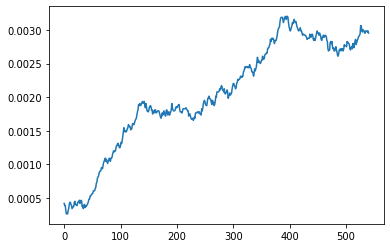

In [10]:
g.plot_reward(smoothing=100)

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [11]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-4].shape[0]//g.eye_observation_size, g.eye_observation_size)
print(x[:-4].reshape(new_shape))
print(x[-4:])
g.to_html()

[[0.71 1.00 1.00 -0.56 0.14]
 [0.74 1.00 1.00 -0.40 -0.23]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 0.74 1.00 0.45 0.16]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.78 1.00 1.00 -0.02 0.34]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.82 1.00 1.00 0.68 0.49]
 [1.00 1.00 1.00 0.00 0.00]
 [0.86 1.00 1.00 -0.57 -0.55]
 [0.61 1.00 1.00 0.30 0.23]
 [0.65 1.00 1.00 0.30 0.23]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.70 1.00 1.00 -0.04 -0.04]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]]
[1.47 -0.31 -0.46 -0.31]


In [12]:
try:
    print('saving')
    target = 'models/karpathy.onnx'
    if tc.save_to_file(target, [brain]):
        print('successfully saved to {}'.format(target))
except Exception as e:
    print(e)
    print('failed to write to "{}"'.format(target))


saving
successfully saved to models/karpathy.onnx
